### 🤖 Implementar ReAct con LangGraph

#### ¿Qué es ReAct?
ReAct (Razonamiento + Actuación) es un framework donde un LLM:

- **Razona paso a paso** (por ejemplo, descompone preguntas, toma decisiones)

- **Actúa** llamando herramientas como búsqueda, calculadoras o recuperadores

Esto lo hace perfecto para RAG Agéntico:
✅ Pensar → Recuperar → Observar → Reflexionar → Respuesta Final

In [3]:
# Importación de librerías necesarias para el sistema ReAct con LangGraph
import os  # Para manejo de variables de entorno

# LangGraph - Framework para construir agentes con grafos
from langgraph.prebuilt import create_react_agent  # Crea un agente ReAct preconfigurado
from langgraph.graph import END  # Constante que marca el final del grafo
from langgraph.graph import StateGraph  # Clase para construir grafos basados en estado
from langgraph.graph.message import add_messages  # Función para agregar mensajes al estado

# LangChain - Framework para aplicaciones con LLMs
from langchain.agents import Tool  # Clase para definir herramientas que el agente puede usar
from langchain.tools import WikipediaQueryRun  # Herramienta para buscar en Wikipedia
from langchain.utilities import WikipediaAPIWrapper  # Wrapper de la API de Wikipedia

# Vector stores y embeddings
from langchain_community.vectorstores import FAISS  # Base de datos vectorial FAISS
from langchain_openai import OpenAIEmbeddings  # Embeddings de OpenAI

# Carga y procesamiento de documentos
from langchain_community.document_loaders import WebBaseLoader  # Cargador de contenido web
from langchain.text_splitter import RecursiveCharacterTextSplitter  # Divisor de texto recursivo

# Typing para definición de tipos
from typing import Annotated, TypedDict, Sequence  # Herramientas de tipado

# Tipos de mensajes de LangChain
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage  # Clases de mensajes

In [4]:
# --------------------------
# 1. Crear Herramienta de Recuperación (Retriever Tool)
# --------------------------

# Cargar contenido desde un blog sobre agentes autónomos
docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()

# Crear un divisor de texto recursivo para particionar el contenido
# chunk_size=500: cada fragmento tendrá máximo 500 caracteres
# chunk_overlap=50: habrá 50 caracteres de superposición entre fragmentos para mantener contexto
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

# Dividir los documentos en fragmentos más pequeños (chunks)
chunks = splitter.split_documents(docs)

# Inicializar el modelo de embeddings de OpenAI
embedding = OpenAIEmbeddings()

# Crear una base de datos vectorial FAISS a partir de los chunks
# Esto convierte cada fragmento en un vector numérico para búsqueda por similitud
vectorstore = FAISS.from_documents(chunks, embedding)

# Crear un retriever (recuperador) a partir del vectorstore
# El retriever permite buscar documentos relevantes dada una consulta
retriever = vectorstore.as_retriever()

In [5]:
# Probar el retriever con una consulta sobre agentes autónomos
# Esto busca en el vectorstore los fragmentos más similares a la pregunta
retriever.invoke("what are autonomous agents")

[Document(id='a597ff97-7379-4f76-ba53-5a1b2a40c320', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [6]:
# Definir la función que ejecutará la herramienta de recuperación RAG
def retriever_tool_func(query: str) -> str:
    """
    Función que busca en la base de conocimiento usando el retriever.
    
    Args:
        query: La pregunta o consulta del usuario
        
    Returns:
        str: Contenido concatenado de los documentos relevantes encontrados
    """
    # Imprimir mensaje indicando que se está usando la herramienta
    print("📚 Usando herramienta RAGRetriever")
    
    # Invocar el retriever con la consulta para obtener documentos relevantes
    docs = retriever.invoke(query)
    
    # Unir el contenido de todos los documentos con saltos de línea
    # Esto devuelve un solo string con toda la información relevante
    return "\n".join([doc.page_content for doc in docs])

In [9]:
# Probar la función de la herramienta directamente
# Esto simula cómo el agente llamará a la herramienta ¿Qué son los agentes autónomos?
retriever_tool_func("what are autonomous agents")

📚 Usando herramienta RAGRetriever


'Or\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferences#\n[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022\n[2] Yao et al. “Tree of Thoughts: Dliberate Problem Solving with Large Language Models.” arXiv preprint arXiv:2305.10601 (2023).\nBoiko et al. (2023) also looked into LLM-empowered agents for scientific discovery, to handle autonomous design, planning, and performance of complex scientific experiments. This agent can use tools to browse the Internet, read documentation, execute code, call robotics experimentation APIs and leverage other LLMs.\nFor example, when requested to "develop a novel anticancer drug", the model came up with the following reasoning steps:\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered

In [10]:
# Crear el objeto Tool para el retriever
# Esto envuelve nuestra función en un formato que LangChain/LangGraph pueden usar
retriever_tool = Tool(
    name="RAGRetriever",  # Nombre único de la herramienta
    description="Usa esta herramienta para obtener información relevante de la base de conocimiento",  # Descripción que ayuda al LLM a decidir cuándo usarla
    func=retriever_tool_func  # Función que se ejecutará cuando se llame a la herramienta
)

# Mostrar el objeto tool
retriever_tool

# Imprimir el nombre de la herramienta para verificar
print(retriever_tool.name)

RAGRetriever


In [11]:
# Crear la herramienta de Wikipedia
# WikipediaQueryRun permite al agente buscar información general en Wikipedia
wiki_tool = WikipediaQueryRun(
    api_wrapper=WikipediaAPIWrapper()  # Wrapper que maneja las llamadas a la API de Wikipedia
)

# Mostrar el objeto wiki_tool
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Udemy\\RAGBootcamp\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [12]:
# Importar librerías necesarias para configurar el modelo de lenguaje
import os  # Para variables de entorno
from langchain.chat_models import init_chat_model  # Función para inicializar modelos de chat
from dotenv import load_dotenv  # Para cargar variables de entorno desde archivo .env

# Configurar la API key de OpenAI desde las variables de entorno
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Inicializar el modelo de chat GPT-4o de OpenAI
# Este será el "cerebro" del agente que razona y decide qué herramientas usar
llm = init_chat_model("openai:gpt-4o")

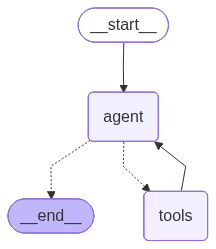

In [13]:
# ----------------------------
# 2. Definir el Nodo del Agente
# ----------------------------

# Crear lista de herramientas disponibles para el agente
# El agente podrá elegir entre estas herramientas según la consulta
tools = [retriever_tool, wiki_tool]

# Crear el agente ReAct nativo de LangGraph
# Este agente implementa el patrón ReAct: Reasoning (razonamiento) + Acting (actuación)
# - Recibe el LLM que tomará las decisiones
# - Recibe las herramientas que puede usar
react_node = create_react_agent(llm, tools)

# Mostrar el agente creado
react_node

In [15]:
# --------------------------
# 3. Estado del Agente LangGraph
# --------------------------

# Definir la clase que representa el estado del agente
class AgentState(TypedDict):
    """
    Define la estructura del estado que fluye a través del grafo.
    
    messages: Lista de mensajes en la conversación
    Annotated[Sequence[BaseMessage], add_messages] indica que:
    - Es una secuencia de mensajes (BaseMessage)
    - Usa add_messages como función reductora para combinar estados
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

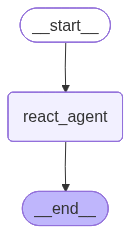

In [16]:
# --------------------------
# 4. Construir el Grafo de LangGraph
# --------------------------

# Crear el constructor del grafo con el tipo de estado definido
builder = StateGraph(AgentState)

# Agregar el nodo del agente ReAct al grafo
# "react_agent" es el nombre del nodo, react_node es la función que se ejecuta
builder.add_node("react_agent", react_node)

# Establecer "react_agent" como punto de entrada del grafo
# Esto significa que la ejecución siempre comenzará aquí
builder.set_entry_point("react_agent")

# Agregar una arista (edge) desde "react_agent" hacia END
# Esto significa que después de ejecutar el agente, el flujo termina
builder.add_edge("react_agent", END)

# Compilar el grafo para hacerlo ejecutable
# La compilación optimiza y valida el grafo
graph = builder.compile()

# Mostrar el objeto del grafo compilado
graph

In [18]:
# --------------------------
# 5. Ejecutar el Agente ReAct
# --------------------------

if __name__ == "__main__":
    # Definir la consulta del usuario
    # Esta pregunta requiere información tanto del retriever como de Wikipedia ¿Qué es un bucle de agente (agent loop) y cómo describe Wikipedia a los agentes autónomos?
    user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
    
    # Crear el estado inicial con el mensaje del usuario
    # HumanMessage representa un mensaje enviado por el usuario
    state = {"messages": [HumanMessage(content=user_query)]}
    
    # Invocar el grafo con el estado inicial
    # El agente procesará la consulta, decidirá qué herramientas usar y generará una respuesta
    result = graph.invoke(state)

    # Imprimir la respuesta final del agente
    # result["messages"][-1] obtiene el último mensaje, que contiene la respuesta final
    print("\n✅ Respuesta Final:\n", result["messages"][-1].content)

📚 Usando herramienta RAGRetriever

✅ Respuesta Final:
 ### Agent Loop

The concept of an "agent loop" relates to the cycle of actions and learning that an autonomous agent undergoes. This involves the use of an artificial intelligence (AI) model, often empowered by large language models (LLMs). The loop consists of the agent performing tasks independently, learning from these actions, and iteratively improving its performance. For example, the agent perceptions is concatenated with learning history and inputted back into the model, with the goal of enhancing future task performance by learning the reinforcement learning process itself rather than training for specific tasks.

### Autonomous Agents

According to Wikipedia, an autonomous agent is a type of artificial intelligence system that is capable of performing complex tasks on its own. It can perceive its environment and take autonomous actions to achieve its objectives, with the potential to enhance its behavior through machine le

### Creación de herramientas para agentes RAG con LangGraph

Para crear herramientas para agentes RAG usando LangGraph, esencialmente estás construyendo funciones invocables por el LLM que tu agente puede llamar como parte de su bucle de razonamiento + actuación (ReAct).

LangGraph usa la abstracción Tool de LangChain y soporta completamente herramientas para:

- Recuperación RAG
- Búsqueda
- Wikipedia
- SQL
- APIs Web
- Calculadoras, etc.

#### ✅ Requisitos de Diseño de Herramientas

Una herramienta de LangGraph debe:

- Tener un **nombre** (identificador único)
- Tener una **descripción** (usada por el LLM para decidir cuándo usarla)
- Tener una **función invocable** (`func`), que acepta una sola entrada (usualmente `str`) y retorna `str`

In [19]:
# Importar todas las librerías necesarias para crear múltiples herramientas RAG
import os  # Para manejo de variables de entorno
from typing import Annotated, Sequence, TypedDict  # Para tipado de datos

# LangChain Tools y utilidades
from langchain.agents import Tool  # Clase base para crear herramientas
from langchain.tools import WikipediaQueryRun  # Herramienta de Wikipedia
from langchain.utilities import WikipediaAPIWrapper  # Wrapper API de Wikipedia

# Vector stores y embeddings
from langchain_community.vectorstores import FAISS  # Base de datos vectorial
from langchain_openai import OpenAIEmbeddings  # Embeddings de OpenAI

# Cargadores de documentos de múltiples fuentes
from langchain_community.document_loaders import WebBaseLoader  # Carga contenido web
from langchain_community.document_loaders import ArxivLoader  # Carga papers de ArXiv
from langchain_community.document_loaders import TextLoader  # Carga archivos de texto

# Text splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter  # División recursiva de texto

# LangGraph
from langgraph.prebuilt import create_react_agent  # Crear agente ReAct
from langgraph.graph import StateGraph, END  # Construcción del grafo
from langgraph.graph.message import add_messages  # Manejo de mensajes

# Tipos de mensajes
from langchain_core.messages import BaseMessage, HumanMessage  # Clases de mensajes

In [20]:
# Verificar que el modelo LLM esté correctamente configurado
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000027718DDC4A0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000027718DF2540>, root_client=<openai.OpenAI object at 0x00000277633BAD80>, root_async_client=<openai.AsyncOpenAI object at 0x0000027718DDC9B0>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [21]:
### Función genérica para crear una herramienta de recuperación desde un archivo de texto
def make_retriever_tool_from_text(file, name, desc):
    """
    Crea una herramienta de recuperación RAG a partir de un archivo de texto.
    
    Args:
        file: Ruta al archivo de texto
        name: Nombre de la herramienta
        desc: Descripción de la herramienta (ayuda al LLM a decidir cuándo usarla)
    
    Returns:
        Tool: Objeto Tool configurado con el retriever
    """
    # Cargar el documento de texto con codificación UTF-8
    docs = TextLoader(file, encoding="utf-8").load()
    
    # Dividir el documento en chunks de 500 caracteres con 50 de superposición
    chunks = RecursiveCharacterTextSplitter(
        chunk_size=500,  # Tamaño máximo de cada fragmento
        chunk_overlap=50  # Superposición entre fragmentos para mantener contexto
    ).split_documents(docs)
    
    # Crear un vectorstore FAISS con los chunks y embeddings de OpenAI
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    
    # Convertir el vectorstore en un retriever
    retriever = vs.as_retriever()

    # Definir la función interna que ejecutará la herramienta
    def tool_func(query: str) -> str:
        """Función que se ejecuta cuando el agente llama a esta herramienta"""
        # Imprimir mensaje indicando qué herramienta se está usando
        print(f"📚 Usando herramienta: {name}")
        
        # Buscar documentos relevantes usando el retriever
        results = retriever.invoke(query)
        
        # Unir el contenido de todos los documentos encontrados
        return "\n\n".join(doc.page_content for doc in results)
    
    # Retornar el objeto Tool configurado
    return Tool(name=name, description=desc, func=tool_func)


# ----------------------------
# Crear Herramienta de Wikipedia
# ----------------------------
wiki_tool = Tool(
    name="Wikipedia",  # Nombre de la herramienta
    description="Usa esta herramienta para obtener conocimiento general del mundo desde Wikipedia.",  # Descripción
    func=WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())  # Función que ejecuta búsquedas en Wikipedia
)


# ----------------------------
# Crear Herramienta de ArXiv
# ----------------------------
def arxiv_search(query: str) -> str:
    """
    Busca papers académicos en ArXiv.
    
    Args:
        query: Consulta de búsqueda
        
    Returns:
        str: Contenido de los papers encontrados (máximo 1000 caracteres por paper)
    """
    # Imprimir mensaje indicando búsqueda en ArXiv
    print("🧪 Buscando en ArXiv...")
    
    # Cargar papers usando ArxivLoader
    results = ArxivLoader(query).load()
    
    # Retornar los primeros 1000 caracteres de los 2 primeros papers encontrados
    # Si no se encuentra nada, retornar mensaje indicativo
    return "\n\n".join(doc.page_content[:1000] for doc in results[:2]) or "No se encontraron papers."

# Crear el objeto Tool para ArXiv
arxiv_tool = Tool(
    name="ArxivSearch",  # Nombre de la herramienta
    description="Usa esta herramienta para obtener papers académicos recientes sobre temas técnicos.",  # Descripción
    func=arxiv_search  # Función de búsqueda
)

In [23]:
# Crear la primera herramienta de documentos internos
# Esta herramienta busca en documentos técnicos internos de la organización
internal_tool_1 = make_retriever_tool_from_text(
    "internal_docs.txt",  # Archivo con documentación técnica interna
    "InternalTechDocs",  # Nombre de la herramienta
    "Busca en documentos técnicos internos para arquitectura propietaria y métodos."  # Descripción
)

# Mostrar el objeto tool creado
internal_tool_1

Tool(name='InternalTechDocs', description='Busca en documentos técnicos internos para arquitectura propietaria y métodos.', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x0000027716C6AFC0>)

In [24]:
# Crear la segunda herramienta de documentos internos
# Esta herramienta busca en notas de investigación interna
internal_tool_2 = make_retriever_tool_from_text(
    "research_notes.txt",  # Archivo con notas de investigación
    "InternalResearchNotes",  # Nombre de la herramienta
    "Busca en notas de investigación interna para resultados experimentales y diseños de agentes."  # Descripción
)

# Mostrar el objeto tool creado
internal_tool_2

Tool(name='InternalResearchNotes', description='Busca en notas de investigación interna para resultados experimentales y diseños de agentes.', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x0000027718730B80>)

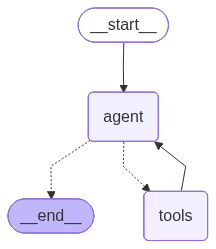

In [25]:
# Crear la lista completa de herramientas disponibles para el agente
# El agente podrá elegir entre estas 4 herramientas según la consulta:
# 1. Wikipedia - conocimiento general
# 2. ArXiv - papers académicos
# 3. InternalTechDocs - documentación técnica interna
# 4. InternalResearchNotes - notas de investigación interna
tools = [wiki_tool, arxiv_tool, internal_tool_1, internal_tool_2]

# Crear el nodo del agente ReAct con el LLM y todas las herramientas
# El agente usará GPT-4o para razonar qué herramienta usar en cada momento
react_node = create_react_agent(llm, tools)

# Mostrar el agente creado
react_node

In [26]:
# Definir la clase de estado para el agente multi-herramienta
class AgentState(TypedDict):
    """
    Estado que fluye a través del grafo del agente.
    
    Attributes:
        messages: Secuencia de mensajes de la conversación
                  Annotated con add_messages para combinar estados correctamente
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

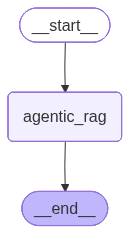

In [27]:
# Construir el grafo de LangGraph para el agente RAG Agéntico
# Crear el constructor con el tipo de estado
builder = StateGraph(AgentState)

# Agregar el nodo del agente con acceso a múltiples herramientas
# "agentic_rag" es el nombre descriptivo del nodo
builder.add_node("agentic_rag", react_node)

# Establecer el punto de entrada del grafo
builder.set_entry_point("agentic_rag")

# Agregar arista al final después del agente
# El flujo va: entrada → agentic_rag → fin
builder.add_edge("agentic_rag", END)

# Compilar el grafo para hacerlo ejecutable
graph = builder.compile()

# Mostrar el grafo compilado
graph

In [28]:
# Definir una consulta compleja que requiere múltiples herramientas
# Esta pregunta necesita:
# 1. InternalResearchNotes - para información interna sobre transformers
# 2. ArXiv - para papers recientes sobre el tema
query = "¿Qué dicen nuestras notas de investigación internas sobre variantes de transformers, y qué sugiere ArXiv recientemente?"

# Crear el estado inicial con el mensaje del usuario
state = {"messages": [HumanMessage(content=query)]}

# Invocar el grafo
# El agente ReAct:
# 1. Analizará la pregunta
# 2. Decidirá usar InternalResearchNotes primero
# 3. Luego usará ArxivSearch
# 4. Combinará la información de ambas fuentes
# 5. Generará una respuesta completa
result = graph.invoke(state)

# Imprimir la respuesta final del agente
# Esta respuesta contendrá información sintetizada de múltiples fuentes
print("\n✅ Respuesta Final:\n", result["messages"][-1].content)

📚 Usando herramienta: InternalResearchNotes
🧪 Buscando en ArXiv...

✅ Respuesta Final:
 ### Notas de Investigación Interna sobre Variantes de Transformers

1. **TinyBERT:**
   - **Aplicación:** Clasificación de tickets de soporte para etiquetado de prioridad.
   - **Evaluación:** 87% de F1 score; confusión en la clase ambigua C.
   - **Adaptabilidad:** Funciona bien con adaptadores FFN de 2 capas para transferencia de dominio.

2. **Experimentos Adicionales:**
   - **FlashAttention2:** Integrado en LLaMA2, reduciendo la latencia de contexto en ~50%.
   - **Chain-of-Thought Prompting:** Mejora en un 8% en tareas lógicas frente a preguntas directas; la reflexión aumenta la precisión en un 3%.
   - **EfficientFormer:** Precisión Top-1 del 92.4% en TinyImageNet; uso de memoria 290MB (batch size = 16); objetivo de despliegue en Raspberry Pi 4, buen rendimiento en modo int8 cuantizado.
   - **Longformer:** Evaluado en registros de soporte al cliente (máx. tokens: 8192); latencia >1.2s por co